In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [7]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('22/frame_00163_pose.txt')

In [8]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

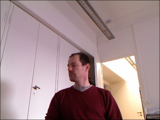

In [9]:
im.to_thumb(160)

In [10]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [11]:
img_files[2]
img2pose(img_files[0])

Path('22/frame_00163_pose.txt')

In [12]:
get_ctr(img_files[0])

tensor([311.6877, 268.2660])

In [13]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                get_items=get_image_files,
                get_y=get_ctr,
                splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                batch_tfms=aug_transforms(size=(240, 320)))

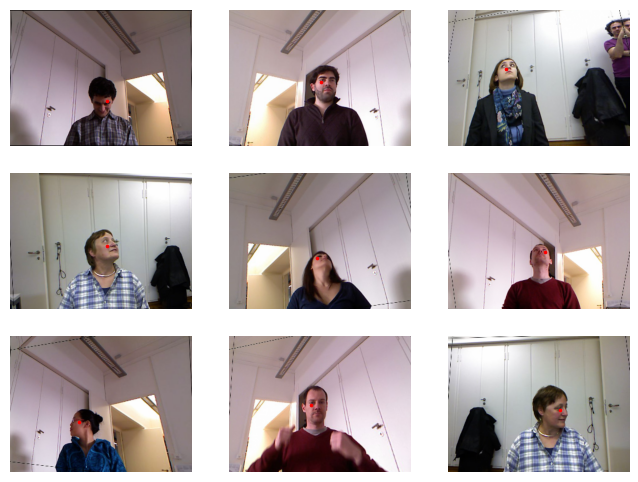

In [14]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [15]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [16]:
yb[0]

TensorPoint([[-0.0976,  0.1475]])

# Training a Model

In [17]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x)*(hi-lo)+lo

In [19]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, 29)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

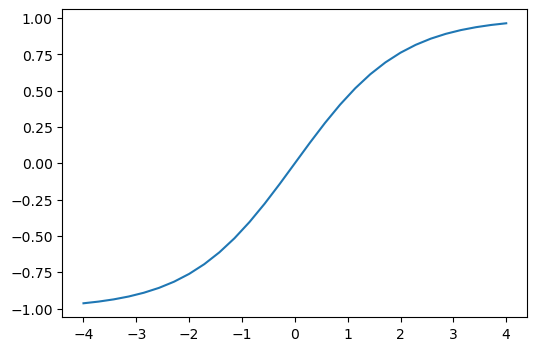

In [20]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [21]:
# check loss function
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

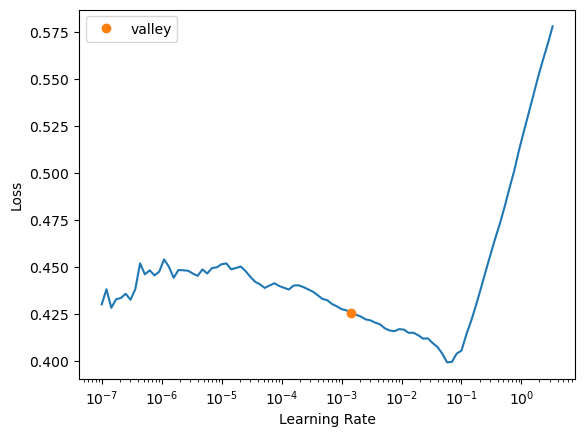

In [22]:
learn.lr_find()

In [26]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.008651,0.000348,39:47


epoch,train_loss,valid_loss,time
0,0.002671,0.000467,56:34
1,0.001643,0.000202,56:47
2,0.001100,0.000105,56:42


In [27]:
math.sqrt(0.0001)

0.01

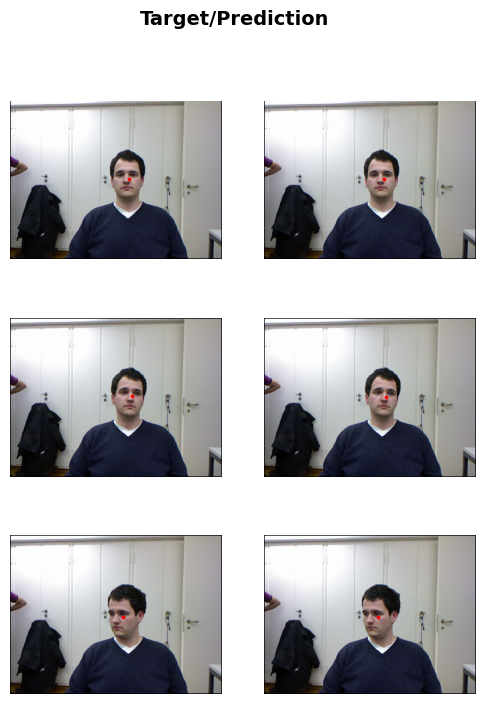

In [28]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))